In [8]:
# 1. Configurations
!pip install bert-score

import os
import zipfile
import json
import random
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score
import time
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Download required NLTK resources
nltk.download('punkt_tab') # for word_tokenize
nltk.download('wordnet') # for METEOR
nltk.download('omw-1.4') # also needed for METEOR

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Set device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Config] Using device: {DEVICE}")

# ========================================
# Set the save path (supporting both Kaggle and Colab simultaneously)
# ========================================
# Detect the operating environment
if 'COLAB_GPU' in os.environ:
    # Colab environment
    from google.colab import drive
    drive.mount('/content/drive')
    SAVE_DIR = '/content/drive/MyDrive/FIT5217/'
    print("Running on Google Colab")
else:
    # Kaggle environment
    SAVE_DIR = '/kaggle/working/'
    print("Running on Kaggle")

os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Save directory: {SAVE_DIR}")

# Define paths
if 'COLAB_GPU' in os.environ:
    # Colab needs to decompress the data first
    #!unzip -q /content/Cooking_Dataset.zip -d /content/
    DATA_ROOT = '/content/Cooking_Dataset'
else:
    # Kaggle
    #DATA_ROOT = '/kaggle/input/Cooking_Dataset'
    DATA_ROOT = '/kaggle/input/cooking-dataset/Cooking_Dataset'
TRAIN_FILE = os.path.join(DATA_ROOT, 'train.csv')
DEV_FILE = os.path.join(DATA_ROOT, 'dev.csv')
TEST_FILE = os.path.join(DATA_ROOT, 'test.csv')

# Define special tokens
PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

# Define hyperparameters for Baseline 2 (Seq2Seq with Attention)
BATCH_SIZE = 8  
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.3
TEACHER_FORCING_RATIO = 0.5
MAX_LENGTH = 100
LEARNING_RATE = 0.001
N_EPOCHS = 5
CLIP = 1.0

# Model name - baseline2
MODEL_NAME = 'baseline2_seq2seq_with_attention'

[Config] Using device: cuda
Running on Kaggle
Save directory: /kaggle/working/


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
# 2. Vocabulary Class
class Vocab:
    """
    Simple vocabulary to map tokens to indices and back.
    """
    def __init__(self):
        self.word2idx = {'<pad>':PAD_token, '<sos>':SOS_token,
                         '<eos>':EOS_token, '<unk>':UNK_token}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.counter  = {}
        self.size     = len(self.word2idx)

    def add_sentence(self, tokens):
        for t in tokens:
            self.add_word(t)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.size
            self.idx2word[self.size] = word
            self.size += 1
            self.counter[word] = 1
        else:
            self.counter[word] += 1

    def encode(self, tokens):
        return [self.word2idx.get(t, UNK_token) for t in tokens]

    def decode(self, indices):
        return [self.idx2word.get(i, '<unk>') for i in indices]

def tokenize(text):
    """
    Very simple whitespace + punctuation tokenizer.
    """
    text = text.lower()
    text = text.replace('.', ' .').replace(',', ' ,')
    return text.split()

def parse_list_string(list_str):
    """
    Parse a string representation of a list into actual list items.
    """
    try:
        return json.loads(list_str)
    except:
        import re
        return re.findall(r'"([^"]*)"', list_str)

In [11]:
# Load and preprocess data
print(f"[Data] Loading data from CSV files...")
train_df = pd.read_csv(TRAIN_FILE)
dev_df = pd.read_csv(DEV_FILE)
test_df = pd.read_csv(TEST_FILE)

# Use 1/4 of the training data to accelerate training
#train_df = train_df.sample(n=len(train_df)//4, random_state=SEED)
#print(f"[Data] Using 1/4 of training data for faster training")

print(f"[Data] train={len(train_df)}, dev={len(dev_df)}, test={len(test_df)}")

# Convert DataFrame to appropriate format
train_raw = []
dev_raw = []
test_raw = []

for _, row in train_df.iterrows():
    train_raw.append({
        'ingredients': parse_list_string(row['Ingredients']),
        'recipe': parse_list_string(row['Recipe'])
    })

for _, row in dev_df.iterrows():
    dev_raw.append({
        'ingredients': parse_list_string(row['Ingredients']),
        'recipe': parse_list_string(row['Recipe'])
    })

for _, row in test_df.iterrows():
    test_raw.append({
        'ingredients': parse_list_string(row['Ingredients']),
        'recipe': parse_list_string(row['Recipe'])
    })

# Build vocabularies
ing_vocab = Vocab()
rec_vocab = Vocab()
for sample in train_raw:
    # ingredients and recipe are lists of strings
    tokens_ing = []
    for ing in sample['ingredients']:
        tokens_ing += tokenize(ing)
    tokens_rec = []
    for step in sample['recipe']:
        tokens_rec += tokenize(step)
    ing_vocab.add_sentence(tokens_ing)
    rec_vocab.add_sentence(tokens_rec)

# ========================================
# Print data statistics information (for PPT)
# ========================================
print("\n" + "="*50)
print("DATA STATISTICS")
print("="*50)
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(dev_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Ingredients vocabulary size: {ing_vocab.size:,}")
print(f"Recipe vocabulary size: {rec_vocab.size:,}")
print(f"Using full dataset: Yes")
print("="*50)

[Data] Loading data from CSV files...
[Data] train=162899, dev=1065, test=1081

DATA STATISTICS
Training samples: 162,899
Validation samples: 1,065
Test samples: 1,081
Ingredients vocabulary size: 18,477
Recipe vocabulary size: 25,450
Using full dataset: Yes


In [12]:
# 4. Dataset & DataLoader
class RecipeDataset(Dataset):
    """
    PyTorch Dataset for (ingredients → recipe) pairs.
    """
    def __init__(self, raw_data, ing_vocab, rec_vocab):
        self.pairs = []
        for sample in raw_data:
            ing_tokens = []
            for ing in sample['ingredients']:
                ing_tokens += tokenize(ing)
            rec_tokens = ['<sos>']
            for step in sample['recipe']:
                rec_tokens += tokenize(step)
            rec_tokens += ['<eos>']
            ing_idx = ing_vocab.encode(ing_tokens)
            rec_idx = rec_vocab.encode(rec_tokens)
            self.pairs.append((ing_idx, rec_idx))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

def collate_fn(batch):
    """
    Collate function to pad and sort sequences by length descending.
    """
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    ing_seqs, rec_seqs = zip(*batch)
    ing_lens = [len(s) for s in ing_seqs]
    rec_lens = [len(s) for s in rec_seqs]
    ing_tensor = pad_sequence([torch.tensor(s) for s in ing_seqs],
                              batch_first=True, padding_value=PAD_token)
    rec_tensor = pad_sequence([torch.tensor(s) for s in rec_seqs],
                              batch_first=True, padding_value=PAD_token)
    return ing_tensor.to(DEVICE), torch.tensor(ing_lens).to(DEVICE), \
           rec_tensor.to(DEVICE), torch.tensor(rec_lens).to(DEVICE)

# Instantiate datasets and dataloaders
train_ds = RecipeDataset(train_raw, ing_vocab, rec_vocab)
dev_ds   = RecipeDataset(dev_raw,   ing_vocab, rec_vocab)
test_ds  = RecipeDataset(test_raw,  ing_vocab, rec_vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn)
print(f"[Loader] {len(train_loader)} train batches, {len(dev_loader)} dev batches.")

[Loader] 20363 train batches, 134 dev batches.


In [13]:
# 5. Model Definitions
class Encoder(nn.Module):
    """
    RNN Encoder that processes input sequences.
    """
    def __init__(self, input_size, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers,
                         batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lengths):
        embedded = self.dropout(self.embedding(src))
        packed = pack_padded_sequence(embedded, src_lengths.cpu(),
                                     batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

class AttentionDecoder(nn.Module):
    """
    RNN Decoder with attention mechanism.
    """
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_size, embedding_dim)
        # Attention mechanism components
        self.attn = nn.Linear(hidden_dim + embedding_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
        
        # RNN with concatenated context
        self.rnn = nn.GRU((hidden_dim + embedding_dim), hidden_dim, n_layers,
                          batch_first=True, dropout=dropout if n_layers > 1 else 0)
        
        # Output projection layer
        self.fc_out = nn.Linear(hidden_dim * 2 + embedding_dim, output_size)
        self.dropout = nn.Dropout(dropout)

    def calculate_attention(self, embedded, hidden, encoder_outputs):
        """
        Calculate attention weights using additive attention.
        """
        # Use last layer hidden state for attention
        hidden = hidden[-1]  # [batch_size, hidden_dim]
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat hidden state and embedded input for each source position
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch_size, src_len, hidden_dim]
        embedded_repeated = embedded.repeat(1, src_len, 1)   # [batch_size, src_len, embedding_dim]
        
        # Concatenate and calculate energy
        emb_hidden = torch.cat((embedded_repeated, hidden), dim=2)
        energy = torch.tanh(self.attn(emb_hidden))  # [batch_size, src_len, hidden_dim]
        attention = self.v(energy).squeeze(2)       # [batch_size, src_len]
        
        return F.softmax(attention, dim=1)

    def forward(self, input, hidden, encoder_outputs):
        """
        Forward pass of attention decoder.
        """
        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, embedding_dim]
        
        # Calculate attention weights
        attn_weights = self.calculate_attention(embedded, hidden, encoder_outputs)
        
        # Apply attention to encoder outputs
        attn_weights_expanded = attn_weights.unsqueeze(1)  # [batch_size, 1, src_len]
        context = torch.bmm(attn_weights_expanded, encoder_outputs)  # [batch_size, 1, hidden_dim]
        
        # Concatenate embedded input with context
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Prepare final prediction
        embedded = embedded.squeeze(1)  # [batch_size, embedding_dim]
        output = output.squeeze(1)      # [batch_size, hidden_dim]
        context = context.squeeze(1)    # [batch_size, hidden_dim]
        
        # Final linear layer
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))
        
        return prediction, hidden, attn_weights

class AttentionSeq2Seq(nn.Module):
    """
    Complete Sequence-to-Sequence model with attention mechanism.
    """
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        """
        Forward pass with teacher forcing.
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size
        
        # Store outputs and attention weights
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src.shape[1]).to(self.device)
        
        # Encode input sequence
        encoder_outputs, hidden = self.encoder(src, src_lengths)
        
        # First input to decoder is <sos> token
        input = trg[:, 0]
        
        # Generate target sequence step by step
        for t in range(1, trg_len):
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t, :] = output
            attentions[:, t, :] = attn
            
            # Teacher forcing: use target token or predicted token
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
            
        return outputs, attentions

In [14]:
# 6. Training and Evaluation Functions
def train_with_iteration_tracking(model, iterator, optimizer, criterion, clip, print_every=500):
    """
    Train the model for one epoch with attention, tracking loss at each iteration.
    """
    model.train()
    epoch_loss = 0.0
    iteration_losses = []
    
    for i, batch in enumerate(iterator, start=1):
        src, src_len, trg, trg_len = batch
        # Move to device
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass - note: attention model returns (outputs, attentions)
        output, _ = model(src, src_len, trg, TEACHER_FORCING_RATIO)
        
        # Reshape for loss calculation
        output_dim = output.shape[-1]
        out = output[:,1:].contiguous().view(-1, output_dim)
        tgt = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(out, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        curr = loss.item()
        iteration_losses.append(curr)
        epoch_loss += curr
        
        if i % print_every == 0:
            print(f"    Iteration {i}/{len(iterator)} | Loss: {curr:.4f}")
    
    return epoch_loss / len(iterator), iteration_losses


def evaluate(model, iterator, criterion):
    """
    Compute average loss over validation/test set with attention model.
    """
    model.eval()
    epoch_loss = 0.0
    
    with torch.no_grad():
        for batch in iterator:
            src, src_len, trg, trg_len = batch
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            
            # Forward pass without teacher forcing - returns (outputs, attentions)
            output, _ = model(src, src_len, trg, 0.0)
            
            output_dim = output.shape[-1]
            out = output[:,1:].contiguous().view(-1, output_dim)
            tgt = trg[:,1:].contiguous().view(-1)
            
            epoch_loss += criterion(out, tgt).item()
    
    return epoch_loss / len(iterator)


def generate_recipe_correct(model, src, src_len, vocab, max_len=100):
    """
    Generate recipe using attention-based seq2seq model.
    Fixed version that works with attention decoder.
    """
    model.eval()
    with torch.no_grad():
        # Encode input sequence
        encoder_outputs, hidden = model.encoder(src, src_len)
        
        # Initialize with SOS token
        batch_size = src.size(0)
        input_tok = torch.tensor([SOS_token] * batch_size).to(DEVICE)
        generated_tokens = [input_tok.clone()]
        
        # Generate sequence step by step
        for t in range(1, max_len):
            # Attention decoder returns (output, hidden, attention_weights)
            output, hidden, _ = model.decoder(input_tok, hidden, encoder_outputs)
            input_tok = output.argmax(1)
            generated_tokens.append(input_tok.clone())
            
            # Stop if all sequences have generated EOS
            if (input_tok == EOS_token).all():
                break
        
        # Stack tokens to form sequences
        sequences = torch.stack(generated_tokens, dim=1)
        return sequences


def calculate_metrics_optimized(predictions, references):
    """
    Calculate BLEU, METEOR, and BERTScore metrics efficiently.
    """
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from bert_score import score
    try:
        from nltk.translate.meteor_score import meteor_score
        meteor_available = True
    except:
        meteor_available = False
    
    bleu_scores = []
    meteor_scores = []
    smoothie = SmoothingFunction().method4
    
    # Calculate BLEU and METEOR for each prediction-reference pair
    for pred, ref in zip(predictions, references):
        if len(pred) > 0 and len(ref) > 0:
            # BLEU-4 score
            bleu = sentence_bleu([ref], pred, weights=(0.25, 0.25, 0.25, 0.25), 
                               smoothing_function=smoothie)
            bleu_scores.append(bleu)
            
            # METEOR score with fallback
            if meteor_available:
                try:
                    meteor = meteor_score([' '.join(ref)], ' '.join(pred))
                    meteor_scores.append(meteor if meteor > 0 else 0.0)
                except:
                    # Fallback to simple overlap metric
                    pred_set = set(pred)
                    ref_set = set(ref)
                    if len(ref_set) > 0:
                        overlap = len(pred_set.intersection(ref_set)) / len(ref_set.union(pred_set))
                        meteor_scores.append(overlap)
                    else:
                        meteor_scores.append(0.0)
    
    # Calculate BERTScore in batches
    try:
        pred_strings = []
        ref_strings = []
        for pred, ref in zip(predictions, references):
            if len(pred) > 0 and len(ref) > 0:
                pred_strings.append(' '.join(pred))
                ref_strings.append(' '.join(ref))
        
        if len(pred_strings) > 0:
            P, R, F1 = score(pred_strings, ref_strings, lang='en', verbose=False, batch_size=64)
            avg_bertscore = F1.mean().item()
        else:
            avg_bertscore = 0.0
    except Exception as e:
        print(f"BERTScore calculation failed: {e}")
        avg_bertscore = 0.0
    
    # Calculate averages
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    
    return {
        'bleu': avg_bleu, 
        'meteor': avg_meteor, 
        'bertscore': avg_bertscore
    }


def decode_sequences(sequences, vocab):
    """
    Convert tensor sequences back to text tokens.
    """
    decoded_recipes = []
    for seq in sequences:
        tokens = []
        for token_id in seq:
            token_id = token_id.item()
            if token_id == EOS_token:
                break
            elif token_id in vocab.idx2word:
                tokens.append(vocab.idx2word[token_id])
        decoded_recipes.append(tokens)
    return decoded_recipes

In [7]:
# 7. Initialize Model & Training
import time
import math
import json

def as_minutes(s: float) -> str:
    """Convert seconds to 'Xm Ys' format."""
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {int(s)}s"

def time_since(start: float, percent: float) -> str:
    """
    Given a start timestamp and progress percent (0–1),
    return elapsed and estimated remaining time.
    """
    now = time.time()
    elapsed = now - start
    estimated_total = elapsed / percent if percent > 0 else 0
    remaining = estimated_total - elapsed
    return f"{as_minutes(elapsed)} (- {as_minutes(remaining)})"

print("="*60)
print("BASELINE 2: SEQ2SEQ WITH ATTENTION")
print("="*60)

# Initialize the encoder and decoder
encoder = Encoder(ing_vocab.size, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = AttentionDecoder(rec_vocab.size, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)

# Initialize the Attention Seq2Seq model
model_base2 = AttentionSeq2Seq(encoder, decoder, DEVICE).to(DEVICE)

# Print model configuration information (for PPT)
total_params = sum(p.numel() for p in model_base2.parameters() if p.requires_grad)
print(f"Model: {model_base2.__class__.__name__}")
print(f"Total trainable parameters: {total_params:,}")
print("\nTraining Configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Hidden dimension: {HIDDEN_DIM}")
print(f"  Number of layers: {N_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Teacher forcing ratio: {TEACHER_FORCING_RATIO}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Number of epochs: {N_EPOCHS}")
print(f"  Gradient clipping: {CLIP}")

# Record hardware information
if torch.cuda.is_available():
    print(f"\nHardware: {torch.cuda.get_device_name(0)}")
else:
    print("\nHardware: CPU")

# Define optimizer and loss function
optimizer = optim.Adam(model_base2.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

# Used for storing training history
history = {
    'train_losses': [],
    'val_losses': [],
    'batch_losses': [],
    'training_time': 0,
    'config': {
        'model_name': MODEL_NAME,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'n_layers': N_LAYERS,
        'dropout': DROPOUT,
        'teacher_forcing_ratio': TEACHER_FORCING_RATIO,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'n_epochs': N_EPOCHS
    }
}

print("\n" + "="*60)
print("TRAINING PROCESS")
print("="*60)

# Training loop with timing
best_valid_loss = float('inf')
training_start = time.time()

print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{N_EPOCHS}")
    
    # Training phase
    train_loss, iteration_losses = train_with_iteration_tracking(
        model_base2, train_loader, optimizer, criterion, CLIP, print_every=500
    )
    history['train_losses'].append(train_loss)
    history['batch_losses'].extend(iteration_losses)
    
    # Validation phase
    valid_loss = evaluate(model_base2, dev_loader, criterion)
    history['val_losses'].append(valid_loss)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    total_elapsed = time.time() - training_start
    progress = (epoch + 1) / N_EPOCHS
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {valid_loss:.4f}")
    print(f"  Epoch Time: {as_minutes(epoch_time)}")
    print(f"  Total Progress: {time_since(training_start, progress)}")
    
    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save complete model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_base2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_valid_loss,
            'config': history['config'],
            'history': history
        }, f'{SAVE_DIR}{MODEL_NAME}_best.pt')
        print(f"  [SAVED] New best model (Val Loss: {valid_loss:.4f})")
    
    # Save epoch checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_base2.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, f'{SAVE_DIR}{MODEL_NAME}_epoch_{epoch+1}.pt')

# Final training summary
total_training_time = time.time() - training_start
history['training_time'] = total_training_time

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Total training time: {as_minutes(total_training_time)}")
print(f"Best validation loss: {best_valid_loss:.4f}")
print(f"Final model saved to: {SAVE_DIR}{MODEL_NAME}_best.pt")

# Save training history
with open(f'{SAVE_DIR}{MODEL_NAME}_history.json', 'w') as f:
    json.dump(history, f)

print("="*60)

BASELINE 2: SEQ2SEQ WITH ATTENTION
Model: AttentionSeq2Seq
Total trainable parameters: 50,544,746

Training Configuration:
  Embedding dimension: 256
  Hidden dimension: 512
  Number of layers: 2
  Dropout: 0.3
  Teacher forcing ratio: 0.5
  Batch size: 8
  Learning rate: 0.001
  Number of epochs: 5
  Gradient clipping: 1.0

Hardware: Tesla P100-PCIE-16GB

TRAINING PROCESS
Starting training at 2025-05-24 02:45:17

Epoch 1/5
    Iteration 500/20363 | Loss: 5.9220
    Iteration 1000/20363 | Loss: 4.7333
    Iteration 1500/20363 | Loss: 5.1536
    Iteration 2000/20363 | Loss: 4.1508
    Iteration 2500/20363 | Loss: 3.9261
    Iteration 3000/20363 | Loss: 4.1165
    Iteration 3500/20363 | Loss: 4.0623
    Iteration 4000/20363 | Loss: 4.3769
    Iteration 4500/20363 | Loss: 4.9871
    Iteration 5000/20363 | Loss: 4.7265
    Iteration 5500/20363 | Loss: 4.2545
    Iteration 6000/20363 | Loss: 4.5399
    Iteration 6500/20363 | Loss: 4.2997
    Iteration 7000/20363 | Loss: 3.9360
    Iteration

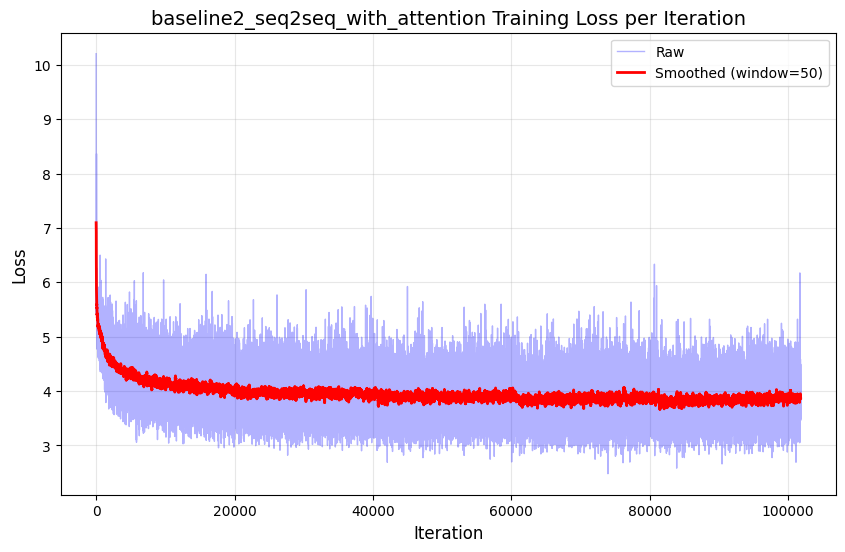

In [8]:
# 8. Plot Training Loss
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d   # moving-average smoothing

# Get batch losses from training history
all_iteration_losses = history['batch_losses']
iters = range(1, len(all_iteration_losses) + 1)

# --- smoothing: simple moving average, window = 50 iterations ---
smoothed = uniform_filter1d(all_iteration_losses, size=50)

plt.figure(figsize=(10, 6))

# raw (noisy) curve – light and thin
plt.plot(iters,
         all_iteration_losses,
         color='blue',
         linewidth=1,
         alpha=0.3,
         label='Raw')

# smoothed curve – thicker and highlighted
plt.plot(iters,
         smoothed,
         color='red',
         linewidth=2,
         label='Smoothed (window=50)')

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'{MODEL_NAME} Training Loss per Iteration', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.savefig(f'{SAVE_DIR}/{MODEL_NAME}_iter_loss.png',
            dpi=300,
            bbox_inches='tight')
plt.show()

In [25]:
# 9. Model Evaluation with Three Metrics
import warnings
warnings.filterwarnings("ignore")

# Load model quietly
MODEL_PATH = "/kaggle/input/code-33446830-base2/baseline2_seq2seq_with_attention_best.pt"
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model_base2.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
model_base2.eval()

# Generate predictions on test set
test_predictions = []
test_references = []

with torch.no_grad():
    for batch in test_loader:
        src, src_len, trg, _ = batch
        pred_sequences = generate_recipe_correct(model_base2, src, src_len, rec_vocab, max_len=MAX_LENGTH)
        
        for j in range(len(pred_sequences)):
            pred_tokens = []
            for token_id in pred_sequences[j]:
                if isinstance(token_id, torch.Tensor):
                    token_id = token_id.item()
                if token_id == EOS_token:
                    break
                if token_id != PAD_token and token_id != SOS_token:
                    pred_tokens.append(rec_vocab.idx2word.get(token_id, '<unk>'))
            
            ref_tokens = []
            for idx in trg[j].cpu().numpy():
                if idx == EOS_token:
                    break
                if idx != PAD_token and idx != SOS_token:
                    ref_tokens.append(rec_vocab.idx2word.get(idx, '<unk>'))
            
            if len(pred_tokens) > 0 and len(ref_tokens) > 0:
                test_predictions.append(pred_tokens)
                test_references.append(ref_tokens)

# Calculate metrics
metrics_base2 = calculate_metrics_optimized(test_predictions, test_references)

# Print clean results only
print("="*50)
print("BASELINE 2 EVALUATION RESULTS:")
print("="*50)
print(f"BLEU-4 Score: {metrics_base2['bleu']:.4f}")
print(f"METEOR Score: {metrics_base2['meteor']:.4f}")
print(f"BERTScore (F1): {metrics_base2['bertscore']:.4f}")
print("="*50)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BASELINE 2 EVALUATION RESULTS:
BLEU-4 Score: 0.0462
METEOR Score: 0.2146
BERTScore (F1): 0.8312


In [26]:
# 10. Save Results for Excel Analysis
import pickle
import pandas as pd

# Generate predictions for all test samples
all_ingredients = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        src, src_len, _, _ = batch
        pred_recipes = generate_recipe_correct(model_base2, src, src_len, rec_vocab, max_len=MAX_LENGTH)
        
        for i in range(src.size(0)):
            # Decode ingredients
            ing_tokens = []
            for idx in src[i].cpu().numpy():
                if idx == PAD_token or idx == EOS_token:
                    break
                if idx != SOS_token:
                    token = ing_vocab.idx2word.get(idx, '<unk>')
                    ing_tokens.append(token)
            
            # Decode predictions
            pred_tokens = []
            for token_id in pred_recipes[i]:
                if isinstance(token_id, torch.Tensor):
                    token_id = token_id.item()
                if token_id == EOS_token:
                    break
                if token_id != PAD_token and token_id != SOS_token:
                    pred_tokens.append(rec_vocab.idx2word.get(token_id, '<unk>'))
            
            all_ingredients.append(' '.join(ing_tokens))
            all_predictions.append(' '.join(pred_tokens))

# Save results in CSV format for Excel
predictions_df = pd.DataFrame({
    'Ingredients': all_ingredients,
    'Recipe - Baseline 2': all_predictions
})

csv_file = f'{SAVE_DIR}baseline2_predictions.csv'
predictions_df.to_csv(csv_file, index=False)

# Save metrics summary
baseline2_results = {
    'model_name': 'Baseline 2 (Seq2Seq with Attention)',
    'bleu4': metrics_base2['bleu'],
    'meteor': metrics_base2['meteor'], 
    'bertscore': metrics_base2['bertscore'],
    'total_samples': len(all_predictions)
}

results_file = f'{SAVE_DIR}baseline2_results.pkl'
with open(results_file, 'wb') as f:
    pickle.dump(baseline2_results, f)

print(f"Results saved: {len(all_predictions)} predictions generated")
print(f"CSV file: baseline2_predictions.csv")
print(f"Results file: baseline2_results.pkl")

Results saved: 1081 predictions generated
CSV file: baseline2_predictions.csv
Results file: baseline2_results.pkl
